In [ ]:
import json
# Load the JSON data
with open('RAW_i.json', 'r') as f:
    data = json.load(f)

print(f"Loaded {len(data)} vehicles from JSON")

# Check the first vehicle
if data:
    vehicle = data[0]
    print(f"\nFields in first vehicle: {list(vehicle.keys())}")


Loaded 789 vehicles from JSON

Fields in first vehicle: ['_id', 'configuration_id', 'local_fragment_id', 'compute_node_id', 'coarse_vehicle_class', 'fine_vehicle_class', 'timestamp', 'raw timestamp', 'first_timestamp', 'last_timestamp', 'road_segment_ids', 'x_position', 'y_position', 'starting_x', 'ending_x', 'camera_snapshots', 'flags', 'length', 'width', 'height', 'velocity', 'direction', 'detection_confidence', 'posterior_covariance', 'detection', 'prior_covariance', 'prior', 'gt_ids', 'leaders', 'gaps', 'feasibility']


In [21]:
print("First vehicle data:")
print(data[0])
# Example: Print the first vehicle's details
# Accessing specific fields
print("Vehicle ID:", data[0]['_id'])

vehicles = data


First vehicle data:
{'_id': {'$oid': '641b0196011a0ef5ce805ea7'}, 'configuration_id': -1, 'local_fragment_id': 2976, 'compute_node_id': 'DEFAULT', 'coarse_vehicle_class': 1, 'fine_vehicle_class': -1, 'timestamp': [1623877161.11, 1623877161.18, 1623877161.32, 1623877161.45, 1623877161.52, 1623877161.58, 1623877161.65, 1623877161.72, 1623877161.78, 1623877161.85, 1623877161.92, 1623877161.99, 1623877162.05, 1623877162.12, 1623877162.19, 1623877162.2514434, 1623877162.3214433, 1623877162.3914435, 1623877162.4514434, 1623877162.5214434, 1623877162.59, 1623877162.65, 1623877162.72, 1623877162.79, 1623877162.8485565, 1623877162.9185567, 1623877162.9885566, 1623877163.0585566, 1623877163.1185565, 1623877163.1871133, 1623877163.2571132, 1623877163.3171132, 1623877163.3871133, 1623877163.45567, 1623877163.5171132, 1623877163.5871131, 1623877163.6571133, 1623877163.7171133, 1623877163.7871132, 1623877163.8571131, 1623877163.9271133, 1623877163.9885566, 1623877164.0571132, 1623877164.12567, 16238

In [25]:
# Extract y_position values from all vehicles
y_positions = []
for vehicle in vehicles:
	y_positions.extend(vehicle["y_position"])

# Calculate min and max
min_y = min(y_positions)
max_y = max(y_positions)

# Calculate range (optional)
range_y = max_y - min_y

# Print results
print(f"Minimum y_position: {min_y} ft")
print(f"Maximum y_position: {max_y} ft")
print(f"Range of y_position: {range_y} ft")

Minimum y_position: 2.352339029312134 ft
Maximum y_position: 119.03050994873047 ft
Range of y_position: 116.67817091941833 ft


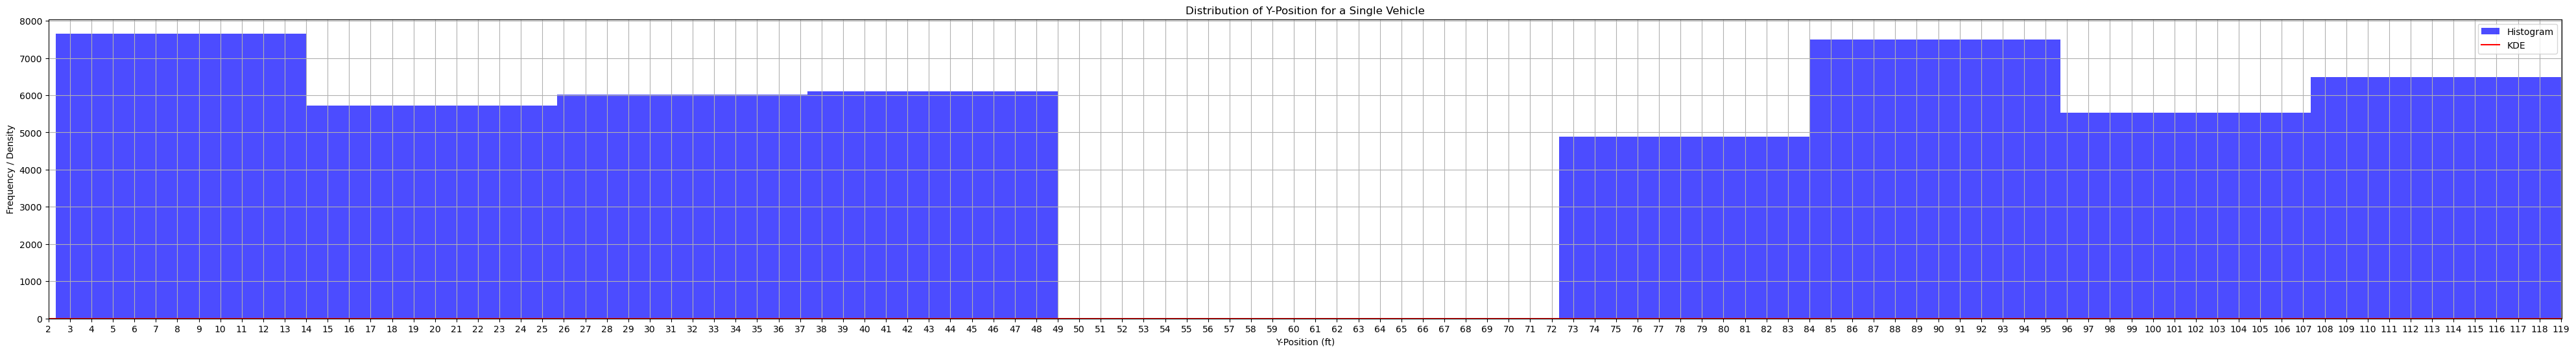

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(50, 6))

# Histogram
plt.hist(y_positions, bins=10, alpha=0.7, color='blue', label='Histogram')

# KDE (optional, requires seaborn)
sns.kdeplot(y_positions, color='red', label='KDE')

# Add labels and title
plt.xlabel("Y-Position (ft)")
plt.ylabel("Frequency / Density")
plt.title("Distribution of Y-Position for a Single Vehicle")
plt.legend()
plt.grid(True)
plt.xlim(min_y, max_y)  # Set x-axis limits to the min and max y_position values
#need in 1 ft increments
plt.xticks([i * 1 for i in range(int(min_y), int(max_y) + 1)])
# Set y-axis limits (optional)
plt.ylim(0, plt.ylim()[1])  # Set y-axis limits to start from 0
# Show plot
plt.show()

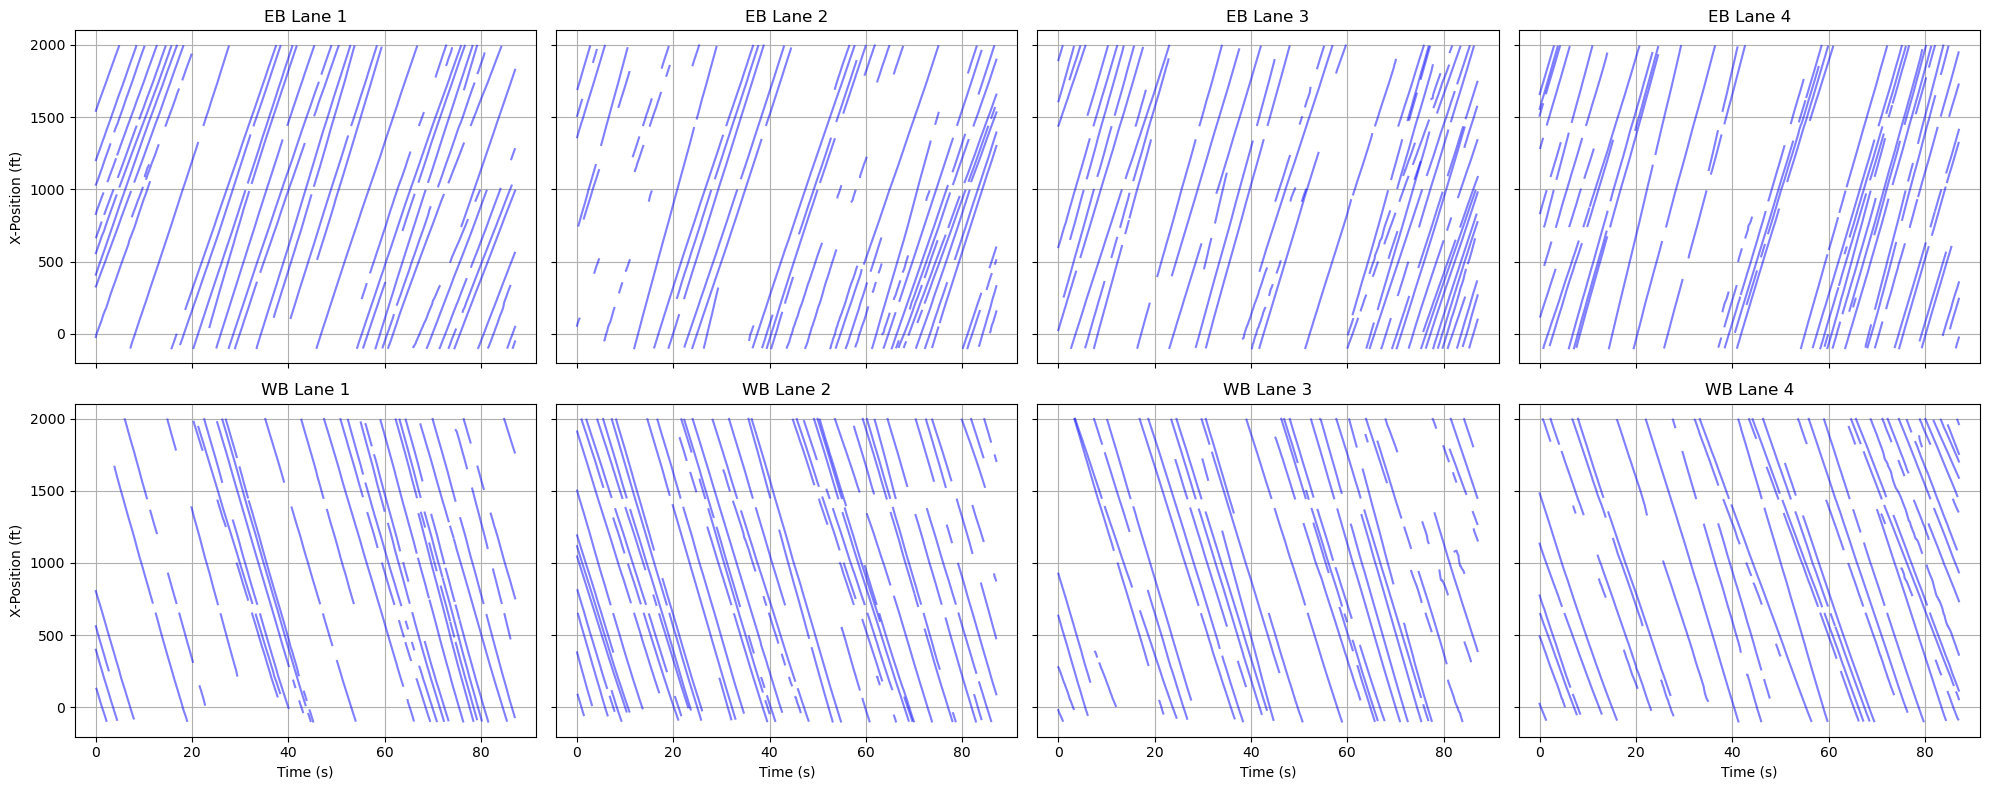

In [ ]:
import matplotlib.pyplot as plt
import json
import glob
import numpy as np

# Load all JSON files (adjust the path to your directory)
json_files = glob.glob("RAW_i.json") 

# Collect y_positions and timestamps by direction
eb_y_positions = []
wb_y_positions = []
all_timestamps = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        # Check if data is a list or a dictionary
        if isinstance(data, list):
            # Process each vehicle in the list
            for vehicle in data:
                if isinstance(vehicle, dict) and "direction" in vehicle:
                    direction = vehicle["direction"]
                    if direction in [1, -1]:
                        y_positions = vehicle["y_position"]
                        all_timestamps.extend(vehicle["timestamp"])
                        if direction == 1:
                            eb_y_positions.extend(y_positions)
                        elif direction == -1:
                            wb_y_positions.extend(y_positions)
        else:
            # Process single vehicle data
            if "direction" in data:
                direction = data["direction"]
                if direction in [1, -1]:
                    y_positions = data["y_position"]
                    all_timestamps.extend(data["timestamp"])
                    if direction == 1:
                        eb_y_positions.extend(y_positions)
                    elif direction == -1:
                        wb_y_positions.extend(y_positions)

# Find min and max y_positions for each direction
min_y_eb = min(eb_y_positions) if eb_y_positions else 0
max_y_eb = max(eb_y_positions) if eb_y_positions else 12
min_y_wb = min(wb_y_positions) if wb_y_positions else -12
max_y_wb = max(wb_y_positions) if wb_y_positions else 0

# Calculate number of lanes (round up to ensure all data is included)
num_lanes_eb = int(np.ceil((max_y_eb - min_y_eb) / 12))
num_lanes_wb = int(np.ceil((max_y_wb - min_y_wb) / 12))
max_lanes = max(num_lanes_eb, num_lanes_wb)

# Define lane boundaries
eb_lane_bounds = [min_y_eb + i * 12 for i in range(num_lanes_eb + 1)]
wb_lane_bounds = [max_y_wb - i * 12 for i in range(num_lanes_wb + 1)][::-1]  # Reverse for descending order

# Find min timestamp for normalization
min_timestamp = min(all_timestamps) if all_timestamps else 0

# Initialize trajectories dictionary
trajectories = {
    "EB": {f"Lane {i+1}": [] for i in range(max_lanes)},
    "WB": {f"Lane {i+1}": [] for i in range(max_lanes)}
}

# Function to assign lane based on y_avg
def get_lane(y_avg, direction):
    if direction == 1:  # Eastbound
        for i in range(len(eb_lane_bounds) - 1):
            if eb_lane_bounds[i] <= y_avg < eb_lane_bounds[i + 1]:
                return i + 1
    elif direction == -1:  # Westbound
        for i in range(len(wb_lane_bounds) - 1):
            if wb_lane_bounds[i] <= y_avg < wb_lane_bounds[i + 1]:
                return i + 1
    return None
# Process each vehicle
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        # Check if data is a list or a dictionary
        if isinstance(data, list):
            # Process each vehicle in the list
            for vehicle in data:
                if not isinstance(vehicle, dict) or "direction" not in vehicle:
                    continue
                direction = vehicle["direction"]
                if direction not in [1, -1]:
                    continue
                y_positions = vehicle["y_position"]
                y_avg = np.mean(y_positions)
                lane = get_lane(y_avg, direction)
                if lane is None or lane > max_lanes:
                    continue
                normalized_timestamps = [t - min_timestamp for t in vehicle["timestamp"]]
                x_positions = vehicle["x_position"]
                trajectory = (normalized_timestamps, x_positions)
                lane_key = f"Lane {lane}"  # Create lane key separately for clarity
                if direction == 1:
                    trajectories["EB"][lane_key].append(trajectory)
                elif direction == -1:
                    trajectories["WB"][lane_key].append(trajectory)
        else:
            # Process single vehicle data
            if not isinstance(data, dict) or "direction" not in data:
                continue
            direction = data["direction"]
            if direction not in [1, -1]:
                continue
            y_positions = data["y_position"]
            y_avg = np.mean(y_positions)
            lane = get_lane(y_avg, direction)
            if lane is None or lane > max_lanes:
                continue
            normalized_timestamps = [t - min_timestamp for t in data["timestamp"]]
            x_positions = data["x_position"]
            trajectory = (normalized_timestamps, x_positions)
            lane_key = f"Lane {lane}"  # Create lane key separately for clarity
            if direction == 1:
                trajectories["EB"][lane_key].append(trajectory)
            elif direction == -1:
                trajectories["WB"][lane_key].append(trajectory)

# Create subplots
fig, axs = plt.subplots(2, max_lanes, figsize=(5 * max_lanes, 8), sharex='all', sharey='row')

# Handle case where max_lanes = 1 (axs becomes 1D)
if max_lanes == 1:
    axs = np.array([axs]).T  # Convert to 2D array for consistent indexing

# Plot EB lanes
for i in range(max_lanes):
    axs[0, i].set_title(f"EB Lane {i + 1}")
    for trajectory in trajectories["EB"][f"Lane {i + 1}"]:
        axs[0, i].plot(trajectory[0], trajectory[1], 'b-', alpha=0.5)
    axs[0, i].grid(True)

# Plot WB lanes
for i in range(max_lanes):
    axs[1, i].set_title(f"WB Lane {i + 1}")
    for trajectory in trajectories["WB"][f"Lane {i + 1}"]:
        axs[1, i].plot(trajectory[0], trajectory[1], 'b-', alpha=0.5)
    axs[1, i].grid(True)

# Set labels
for ax in axs[1, :]:
    ax.set_xlabel("Time (s)")
for ax in axs[:, 0]:
    ax.set_ylabel("X-Position (ft)")

plt.tight_layout()
plt.show()